<a href="https://colab.research.google.com/github/battistabiggio/ai4dev/blob/main/notebooks/AI4Dev_04_dnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch

In this notebook, we will look at PyTorch Tensors and introduce all the components used to implement deep learning one by one. 
Remember that the primary source of information, that also describes all the APIs and classes discussed in this notebook (and way more), is the [PyTorch documentation](https://pytorch.org/docs/stable/index.html).

We can technically use numpy arrays for learning, but there are several aspects that they don't cover.

In `PyTorch`, the `Tensor` class is more powerful than standard numeric libraries.

* GPU support
* Parallel operations on multiple devices or machines
* Tensors keep track of graph of computations that created them (needed for gradients)

All these features, especially the last one, are of utmost importance when dealing with deep learning!

Mostly, the APIs for math operations resemble the ones of Numpy - but only from the exterior...

In [1]:
import torch
x = torch.tensor([1., 2.])
w = torch.tensor([2., 2.])

# indexing operations as usual
# the .item() extracts the element if it's only one number
print("first element of w: ", w[0].item())

first element of w:  2.0


... in the backstage, as specified, Tensors also keep track of the operations in the computational graph. This means that if we perform operations with tensors, we are able to retrieve all the computations from the end node to the beginning (leaves). This is needed to compute gradients automatically!

In [2]:
# set tracking gradients to true, this will
# rememeber all operations performed to w
w.requires_grad = True

# operations as usual
f = w.t().dot(x)

# compute gradients
f.backward()

# gradient of f w.r.t. w is x
print("gradient of f w.r.t. w")
print(w.grad)

gradient of f w.r.t. w
tensor([1., 2.])


## Additional information on Tensor storage

**Remember**: the underlying memory is allocated only once, which makes the view operation very lightweigth even for large storages. Even assigning another variable to the tensor only copies the reference!

To retrieve the location of a tensor in memory, we can use the `data_ptr()` method:
- https://pytorch.org/docs/stable/generated/torch.Tensor.data_ptr.html#torch-tensor-data-ptr


In [3]:
a = torch.tensor([1, 2, 3, 4])
b = a[0]  # different Tensor, same storage (points to the same location)
c = a.reshape([2, 2])  # same storage, different stride

print("storage of a == storage of c")
print(a.data_ptr() == c.data_ptr())  # same storage

storage of a == storage of c
True


If we modify the tensor c, we also indirectly modify the tensor a!

To create a copy and duplicate the tensor, we can use the `Tensor.clone()` API.

In [4]:
c[0] = 1
print("let's modify the first element of c")

print("as you can see, the tensor is the same, and c is only a reference")
print("first element of c", c[0])
print("first element of a", a[0])

print("storage of a == storage of c")
print(a.data_ptr() == c.data_ptr())

let's modify the first element of c
as you can see, the tensor is the same, and c is only a reference
first element of c tensor([1, 1])
first element of a tensor(1)
storage of a == storage of c
True


In [5]:
a = torch.tensor([1, 2, 3, 4])
d = a.clone()

print("storage of a == storage of d")
print(a.data_ptr() == d.data_ptr())

d[0] = 5
print("first element of d", d[0])
print("first element of a", a[0])

storage of a == storage of d
False
first element of d tensor(5)
first element of a tensor(1)


To reshape a Tensor, we have two APIs (mostly interchangeable for us, but they have subtle differences related to the storage).

To find out more:
- https://pytorch.org/docs/stable/generated/torch.reshape.html#torch.reshape
- https://discuss.pytorch.org/t/whats-the-difference-between-torch-reshape-vs-torch-view/159172

In [6]:
a = torch.tensor([1, 2, 3, 4, 5, 6])
b = a.reshape((2, 3))
c = a.view((3, 2))

print("stride of a")
print(a.stride())  # how many storage items to skip for incrementing each dimension

print("stride of b")
print(b.stride())  # how many storage items to skip for incrementing each dimension

print("stride of c")
print(c.stride())  # how many storage items to skip for incrementing each dimension

stride of a
(1,)
stride of b
(3, 1)
stride of c
(2, 1)


## Learning with tensors

We can now use PyTorch to learn from tensors, given it's ability to track the operations. 
We will start with a simple **regression** problem, where we try to estimate a value given an underlying distribution of points.

We do this by estimating the parameters of a line that passes through the points, thus once we have the value $x$, we can immediately compute $y=f(x) = w^T x$.

First, let's create a dataset of points with scikit-learn. We will use one feature, that will be our `x`. We can wrap numpy arrays into tensors with the `tensor.from_numpy()` method.


In [7]:
import torch
from sklearn import datasets

samples, labels = datasets.make_regression(n_samples=1000, n_features=1, noise=2, random_state=42)

samples, labels = torch.from_numpy(samples.ravel()).type(torch.float32), torch.from_numpy(labels).type(torch.float32)

# normalization
samples -= samples.min()
samples /= samples.max()

print(samples[:5], labels[:5])


tensor([0.2090, 0.6024, 0.3882, 0.4832, 0.5592]) tensor([-30.1187,  14.5262, -10.1193,   1.7002,  12.3453])


Let's plot the points with `matplotlib.pyplot.scatter`.

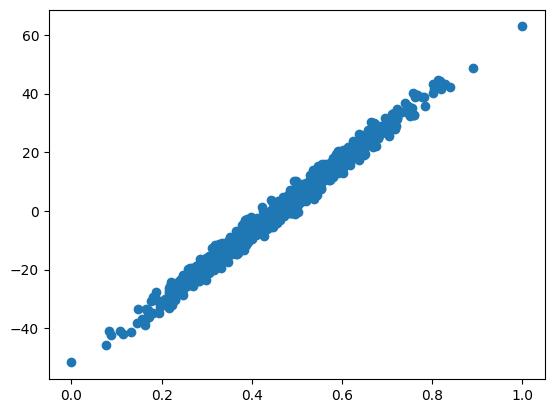

In [8]:
import matplotlib.pyplot as plt

plt.scatter(samples, labels)

Let's define a model that computes the $f(x)$. For now, let's stick to using python functions. Note that if the inputs of the function are tensors, all operations will also be tracked there.

In [9]:
def model(x, w, b):
    return w * x + b

We can plot the model with the usual trick of defining a range of values for x and predicting with our model function the values for y. Then, we use `matplotlib.pyplot.plot` to draw the line.

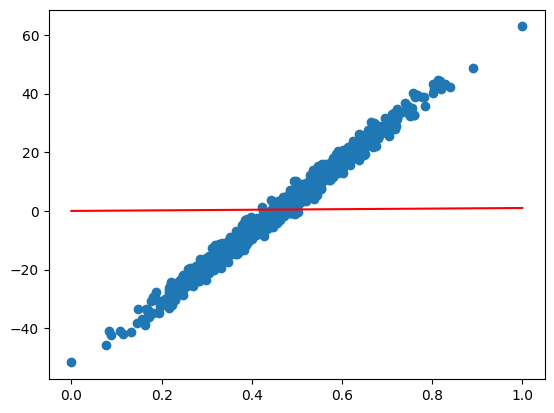

In [10]:
def plot_line(w, b, alpha=1.0):
    x_axis = torch.linspace(0, 1, 100)
    y_axis = model(x_axis, w, b)
    plt.plot(x_axis.detach().numpy(), y_axis.detach().numpy(), color='r', alpha=alpha)

def plot_points(samples, labels):
    plt.scatter(samples.cpu().numpy(), labels.cpu().numpy())

w, b = torch.tensor([1.0]), torch.tensor([0.0])

plot_line(w, b)
plot_points(samples, labels)


Then, we should write a loss function to perform gradient descent on the parameters (w and b) of our model.
First, let's compute the gradients "by hand".

$$
\displaystyle L(w, b, x) = \frac{1}{n} \sum_{i=1}^{n} \left(y_i - (w^T x_i + b)\right)^2
$$

Then, the derivative of the loss w.r.t. $w$ is:

$$
\frac{\partial{L}}{\partial{w}} = \frac{1}{n} \sum_{i=1}^{n} 2 \left(y_i - (w^T x_i + b)\right) * x
$$

While the gradient of L w.r.t. b is:

$$
\frac{\partial{L}}{\partial{b}} = \frac{1}{n} \sum_{i=1}^{n} 2 \left(y_i - (w^T x_i + b)\right) * 1
$$

In [11]:
def loss_fn(y_pred, y_true):
    squared_diffs = (y_pred - y_true)**2
    return squared_diffs.mean()

def grad_l_w(x, w, b, y):
    return (2*x*(w.t() * x + b - y)).mean()

def grad_l_b(x, w, b, y):
    return (2*(w.t() * x + b - y)).mean()


initial parameters
tensor([1.]) tensor([0.])
Iteration 0, loss: 267.3998107910156
Iteration 100, loss: 141.0691375732422
Iteration 200, loss: 75.46051025390625
Iteration 300, loss: 41.2375602722168
Iteration 400, loss: 23.386056900024414
Iteration 500, loss: 14.074280738830566
Iteration 600, loss: 9.217048645019531
Iteration 700, loss: 6.683408737182617
Iteration 800, loss: 5.361809253692627
Iteration 900, loss: 4.672428607940674
Iteration 1000, loss: 4.312826156616211
Iteration 1100, loss: 4.125248432159424
Iteration 1200, loss: 4.027410984039307
Iteration 1300, loss: 3.976372480392456
Iteration 1400, loss: 3.949751853942871
Iteration 1500, loss: 3.9358649253845215
Iteration 1600, loss: 3.928621530532837
Iteration 1700, loss: 3.924842596054077
Iteration 1800, loss: 3.9228711128234863
Iteration 1900, loss: 3.9218437671661377
final parameters
tensor([118.4743]) tensor([-54.1206])


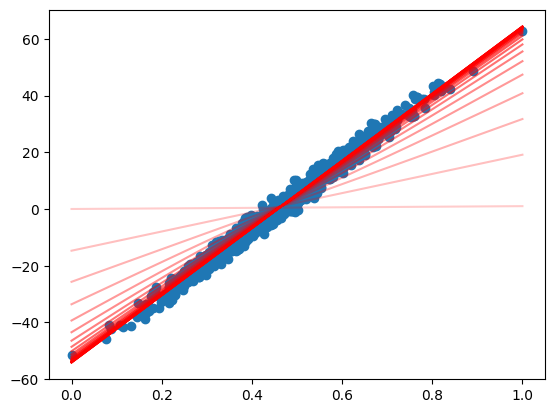

In [12]:
w, b = torch.tensor([1.0]), torch.tensor([0.0])

print("initial parameters")
print(w, b)

n_steps = 2000
step_size = 0.1

# plot the points
plot_points(samples, labels)

for i in range(n_steps):
    y_pred = model(samples, w, b)
    loss = loss_fn(y_pred, labels)
    if i % 100 == 0:
        # print loss value and plot line with increasing alpha
        print(f"Iteration {i}, loss: {loss.item()}")
        plot_line(w, b, alpha=min(1.0, 0.2 + i/n_steps))
    w = w - step_size * grad_l_w(samples, w, b, labels)
    b = b - step_size * grad_l_b(samples, w, b, labels)

# plot final line
plot_line(w, b)

print("final parameters")
print(w, b)



If we don't want to compute the gradients by hand, we can also leverage the automatic gradient from PyTorch. The way we use it is:

1. we compute the `forward` pass, that constructs the graph from the original tensors to the end of the graph (the loss node).
2. we run the `backward`, that goes through the graph in reverse and accumulates the gradients

The accumulation is a key concept. Since the graphs usually perform the computation for multiple samples at once, the default behavior of PyTorch is to accumulate all gradients in each node unless specified otherwise (by zero-ing operations).

Let's compute the loss and print its value. We will notice an additional item in the output.

In [13]:
# now let's pack the parameters in one single tensor for convenience
params = torch.tensor([1.0, 0.0], requires_grad=True)

loss = loss_fn(model(samples, *params), labels)
print(f"loss: {loss}")

loss.backward()

loss: 267.3998107910156


Notice that the printed tensor also contain a reference to a gradient function. This is the previous node of the graph. This is needed for the chain rule, in fact, remember how we compute the derivative of a composite function:

$$
\frac{\partial{L}}{\partial{z}} = \frac{\partial{L}}{\partial{u}} \frac{\partial{u}}{\partial{z}}
$$

Thus, to compute the full gradient of the loss w.r.t. $w$, we have to compute the corresponding $\frac{\partial{u}}{\partial{z}}$ of every operation and multiply by the first gradient encountered in the backward. Then, to get the next, we have to compute again the partial derivative of the next operation w.r.t. the previous node.

This is all handled by PyTorch, thus we can directly access the gradient in the variable where we need it:


In [14]:
print("gradient of params")
print(params.grad)

gradient of params
tensor([-4.3618,  0.2545])


Remember also that the gradient stays there until we reset it. This means that if we run again a forward and a backward, we will fin 2*gradient in this variable.


In [15]:
loss = loss_fn(model(samples, *params), labels)
print(f"loss: {loss}")

loss.backward()

print("gradient accumulated after two backwards")
print(params.grad)

loss: 267.3998107910156
gradient accumulated after two backwards
tensor([-8.7236,  0.5090])


If we want to perform gradient descent, in each iteration we need to:

1. compute the gradient
2. update the parameters with the gradient
3. clear the gradient from the node

At the moment, we can use the inplace operation `tensor.zero_()` to set to zero the gradients after use.

In [16]:
# remove the gradients for the next computation
params.grad.zero_()

print("gradients of w after zero-ing")
print(params.grad)

gradients of w after zero-ing
tensor([0., 0.])


initial parameters: 
tensor([1., 0.], requires_grad=True)
Epoch: 0, Loss 267.399811
Epoch: 100, Loss 144.266098
Epoch: 200, Loss 78.830009
Epoch: 300, Loss 43.903580
Epoch: 400, Loss 25.261570
Epoch: 500, Loss 15.311401
Epoch: 600, Loss 10.000488
Epoch: 700, Loss 7.165797
Epoch: 800, Loss 5.652781
Epoch: 900, Loss 4.845216
Epoch: 1000, Loss 4.414173
Epoch: 1100, Loss 4.184098
Epoch: 1200, Loss 4.061301
Epoch: 1300, Loss 3.995757
Epoch: 1400, Loss 3.960771
Epoch: 1500, Loss 3.942100
Epoch: 1600, Loss 3.932132
Epoch: 1700, Loss 3.926813
Epoch: 1800, Loss 3.923973
Epoch: 1900, Loss 3.922458
final parameters: 
tensor([118.4291, -54.0993], requires_grad=True)


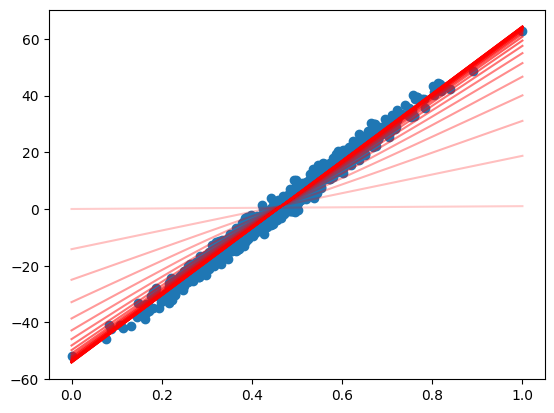

In [17]:
def training_loop(n_epochs, learning_rate, params, x, y):
    plot_points(x, y)
    for epoch in range(n_epochs):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y)
        loss.backward()
        if epoch % 100 == 0:
            print("Epoch: %d, Loss %f" % (epoch, float(loss)))
            plot_line(*params, alpha=min(1.0, 0.2 + epoch/n_epochs))
        with torch.no_grad():
            params -= learning_rate * params.grad
        params.grad.zero_()
    plot_line(*params)
    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)
print("initial parameters: ")
print(params)
trained_params = training_loop(2000, 1e-1, params, samples, labels)
print("final parameters: ")
print(trained_params)

Then, we can also use the optimizers from PyTorch to perform the update of the parameters.
We have to pass to the constructor the set of parameters (even multiple ones) that we need to update. PyTorch will automatically track the gradients on these and use the gradients to update them, according to the "rules" of the optimizer defined. Let's for example use the Adam optimizer: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html


initial parameters
tensor([1., 0.], requires_grad=True)
Epoch 0, Loss 267.399811
Epoch 100, Loss 225.070465
Epoch 200, Loss 188.033401
Epoch 300, Loss 155.879776
Epoch 400, Loss 128.174423
Epoch 500, Loss 104.498398
Epoch 600, Loss 84.448830
Epoch 700, Loss 67.639252
Epoch 800, Loss 53.699860
Epoch 900, Loss 42.278790
Epoch 1000, Loss 33.043415
Epoch 1100, Loss 25.682095
Epoch 1200, Loss 19.905592
Epoch 1300, Loss 15.448988
Epoch 1400, Loss 12.073524
Epoch 1500, Loss 9.567025
Epoch 1600, Loss 7.745009
Epoch 1700, Loss 6.450434
Epoch 1800, Loss 5.552685
Epoch 1900, Loss 4.946012
final parameters
tensor([112.9129, -51.5653], requires_grad=True)


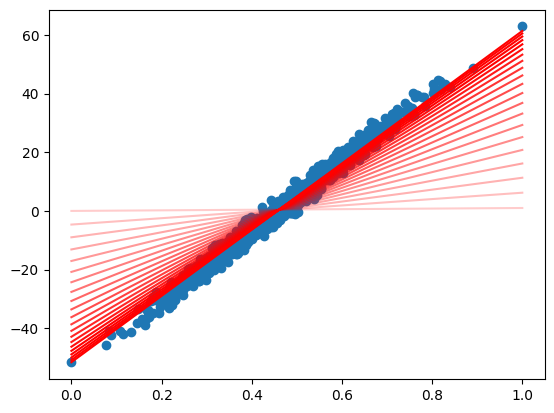

In [18]:
from torch.optim import Adam


def training_loop(n_epochs, learning_rate, params, x, y):
    # define the optimizer
    optimizer = Adam([params], lr=learning_rate)
    for epoch in range(n_epochs):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y)
        loss.backward()
        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            plot_line(*params, alpha=min(1.0, 0.2 + epoch/n_epochs))
        # update the parameters
        optimizer.step()
        # clears the gradients on the parameters
        optimizer.zero_grad()
    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)

print("initial parameters")
print(params)
training_loop(2000, 1e-1, params, samples, labels)

plot_line(*params)
plot_points(samples, labels)
print("final parameters")
print(params)


Now let's introduce also a scheduler that will reduce the step size during training. We can update the step size by calling `scheduler.step()`. 
We will use now a `MultiStepLR`, which takes a set of milestones in which it will decay the step size by a factor `gamma`.

initial parameters
tensor([1., 0.], requires_grad=True)
Epoch 0, Loss 267.399811
Epoch 100, Loss 144.266098
Epoch 200, Loss 78.830009
Epoch 300, Loss 43.903580
Epoch 400, Loss 25.261570
Epoch 500, Loss 15.311401
Epoch 600, Loss 10.000488
Epoch 700, Loss 7.165797
Epoch 800, Loss 5.652781
Epoch 900, Loss 5.186451
Epoch 1000, Loss 5.002790
Epoch 1100, Loss 4.921227
Epoch 1200, Loss 4.845812
Epoch 1300, Loss 4.776081
Epoch 1400, Loss 4.711606
Epoch 1500, Loss 4.651992
Epoch 1600, Loss 4.596870
Epoch 1700, Loss 4.545904
Epoch 1800, Loss 4.498781
Epoch 1900, Loss 4.455210
final parameters
tensor([113.5611, -51.8262], requires_grad=True)


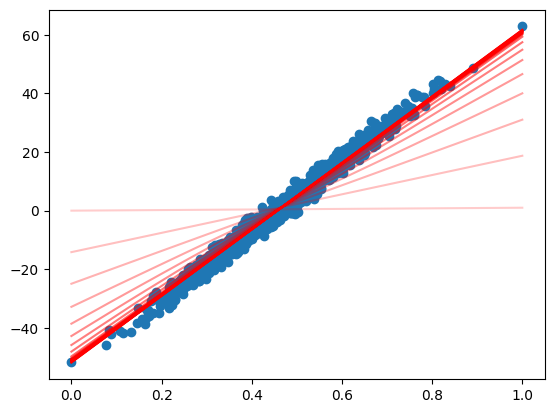

In [19]:
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR


def training_loop(n_epochs, learning_rate, params, x, y):
    optimizer = SGD([params], lr=learning_rate)
    scheduler = MultiStepLR(optimizer, milestones=[800, 900, 1000], gamma=0.5)

    for epoch in range(n_epochs):
        y_pred = model(x, *params)
        loss = loss_fn(y_pred, y)
        loss.backward()
        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            plot_line(*params, alpha=min(1.0, 0.2 + epoch/n_epochs))
        # update the parameters
        optimizer.step()
        # clears the gradients on the parameters
        optimizer.zero_grad()
        # updates the learning rate according to the scheduler rule
        scheduler.step()
    return params

params = torch.tensor([1.0, 0.0], requires_grad=True)

print("initial parameters")
print(params)
# let's start from a bigger learning rate
training_loop(2000, 1e-1, params, samples, labels)

plot_line(*params)
plot_points(samples, labels)
print("final parameters")
print(params)

Let's now also replace the model function with a model from PyTorch. The simple linear model is implemented in the `torch.nn.Linear` class.

(We have to modify the function to plot the model and the samples and labels slightly)

initial parameters
-0.4091498851776123 -0.5479980707168579
Epoch 0, Loss 274.874237
Epoch 100, Loss 29.962955
Epoch 200, Loss 8.702641
Epoch 300, Loss 4.430103
Epoch 400, Loss 3.951909
Epoch 500, Loss 3.921813
Epoch 600, Loss 3.920908
Epoch 700, Loss 3.920748
Epoch 800, Loss 3.920726
Epoch 900, Loss 3.920723
Epoch 1000, Loss 3.920723
Epoch 1100, Loss 3.920723
Epoch 1200, Loss 3.920723
Epoch 1300, Loss 3.920723
Epoch 1400, Loss 3.920723
Epoch 1500, Loss 3.920723
Epoch 1600, Loss 3.920723
Epoch 1700, Loss 3.920723
Epoch 1800, Loss 3.920723
Epoch 1900, Loss 3.920723
final parameters
118.6490707397461 -54.202030181884766


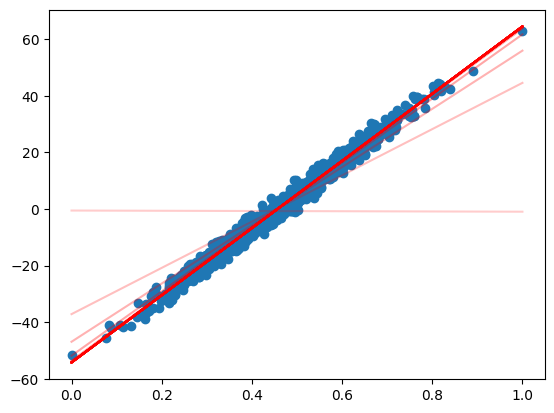

In [20]:
def plot_module(model, alpha=1.0):
    x_axis = torch.linspace(0, 1, 100).unsqueeze(1).to(list(model.parameters())[0].device)
    y_axis = model(x_axis)
    plt.plot(x_axis.detach().cpu().numpy(), y_axis.detach().cpu().numpy(), color='r', alpha=alpha)

def training_loop_module(n_epochs, learning_rate, model, x, y):  # changed params to model
    x, y = x.float().unsqueeze(1), y.float().unsqueeze(1)
    optimizer = Adam(model.parameters(), lr=learning_rate)  # changed [params] to model.parameters()
    scheduler = MultiStepLR(optimizer, milestones=[100, 500, 1000], gamma=0.5)
    criterion = torch.nn.MSELoss()

    plot_points(x, y)

    for epoch in range(n_epochs):
        y_pred = model(x)  # changed line
        loss = criterion(y_pred, y)
        loss.backward()
        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            plot_module(model, alpha=min(1.0, 0.2 + epoch/n_epochs))
        # update the parameters
        optimizer.step()
        # clears the gradients on the parameters
        optimizer.zero_grad()
        # updates the learning rate according to the scheduler rule
        scheduler.step()
    
    plot_module(model)

    return

linear_model = torch.nn.Linear(1, 1)

print("initial parameters")
print(linear_model.weight.item(), linear_model.bias.item())

training_loop_module(2000, 1.0, linear_model, samples, labels)

plot_module(linear_model)
print("final parameters")
print(linear_model.weight.item(), linear_model.bias.item())

And then, we can replace the linear layer with a composite (non-linear) PyTorch model. For now, let's use the `torch.nn.Sequential`, that allows us to list the sequence of layers and activations, that will be applied in cascade.

Epoch 0, Loss 272.348114
Epoch 100, Loss 166.166428
Epoch 200, Loss 52.674835
Epoch 300, Loss 7.832198
Epoch 400, Loss 4.562678
Epoch 500, Loss 4.265601
Epoch 600, Loss 4.199928
Epoch 700, Loss 4.156631
Epoch 800, Loss 4.128063
Epoch 900, Loss 4.106481
Epoch 1000, Loss 4.087182
Epoch 1100, Loss 4.077781
Epoch 1200, Loss 4.068508
Epoch 1300, Loss 4.059444
Epoch 1400, Loss 4.050485
Epoch 1500, Loss 4.041658
Epoch 1600, Loss 4.033303
Epoch 1700, Loss 4.025354
Epoch 1800, Loss 4.017725
Epoch 1900, Loss 4.010303


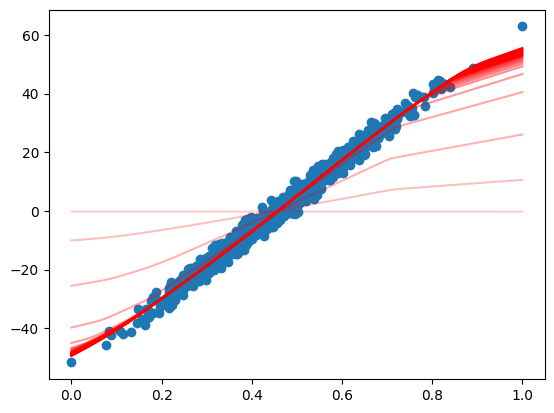

In [21]:
dnn = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

training_loop_module(2000, 1e-3, dnn, samples, labels)

The advantage of having a non-linear model is that now we can also perform regression on non-linear distributions of samples.
Let's modify the y so that the function mapping between x and y is not linear anymore, and let's visualize the new distribution.

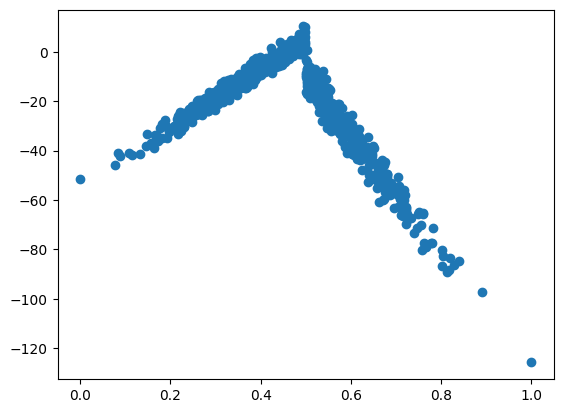

In [22]:
y_new = labels.clone()
y_new[samples>0.5] *= -2

plot_points(samples, y_new)

Epoch 0, Loss 703.183350
Epoch 100, Loss 108.984406
Epoch 200, Loss 14.516885
Epoch 300, Loss 14.480760
Epoch 400, Loss 14.473760
Epoch 500, Loss 14.467983
Epoch 600, Loss 14.465748
Epoch 700, Loss 14.463138
Epoch 800, Loss 14.459688
Epoch 900, Loss 14.456494


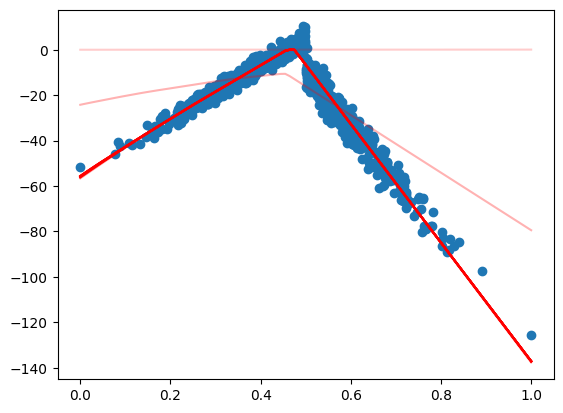

In [23]:
y_new = labels.clone()
y_new[samples>0.5] *= -2

dnn = torch.nn.Sequential(
    torch.nn.Linear(1, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
)

training_loop_module(1000, 1e-2, dnn, samples, y_new)

plot_module(dnn)

Finally, let's see how neural networks are implemented in PyTorch.
We write a class that inherits the `torch.nn.Module`, that is the base of all differentiable modules in the library (including the losses). 
In the `__init__` we define the layers, and all parameters will be initialized automatically (also with better distributions than setting them manually). Additionally, all parameters initialized here will be accessible by using `model.parameters()` and inspected recursively. 

The other thing to implement here is the method `forward`, that defines all the operations performed on the input. When we want the output from our model, we call `model(x)` and this will call the forward method (along with other operations before and after, that are missed if you call `model.forward(x)`. As a rule, always use the `__call__` method).

Epoch 0, Loss 701.570435
Epoch 100, Loss 29.362801
Epoch 200, Loss 14.455504
Epoch 300, Loss 14.452793
Epoch 400, Loss 14.450368
Epoch 500, Loss 14.447521
Epoch 600, Loss 14.445922
Epoch 700, Loss 14.444143
Epoch 800, Loss 14.442265
Epoch 900, Loss 14.440234


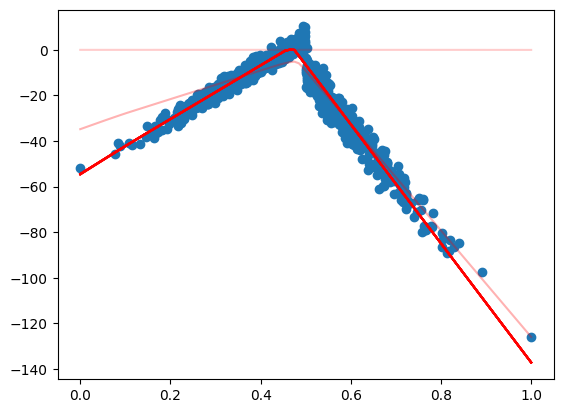

In [24]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """Defines the layers"""
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 100)
        self.fc2 = torch.nn.Linear(100, 100)
        self.out = torch.nn.Linear(100, 1)
        # no need to define the relu twice
        # we can call it in the forward
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """Defines the operations applied to x"""
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        out = self.out(x)
        return out

dnn_2 = NeuralNetwork()
training_loop_module(1000, 1e-2, dnn_2, samples, y_new)

plot_module(dnn_2)

## Using GPUs

We can move the computation to run on a Graphic Processing Unit (GPU) with a few simple lines. Note that if we run any operation on a GPU, all elements should be in the device. Thus, if we want to use our model in the GPU, we should take care of moving also the samples and labels. The rest of the code remains the same.

Epoch 0, Loss 695.470825
Epoch 100, Loss 15.784055
Epoch 200, Loss 14.456752
Epoch 300, Loss 14.453791
Epoch 400, Loss 14.450813
Epoch 500, Loss 14.447541
Epoch 600, Loss 14.445776
Epoch 700, Loss 14.443810
Epoch 800, Loss 14.441675
Epoch 900, Loss 14.439445


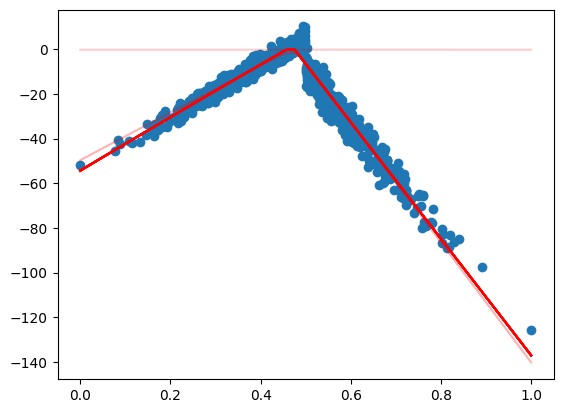

In [25]:
dnn_3 = NeuralNetwork()

device = "cuda" if torch.cuda.is_available() else "cpu"
dnn_3 = dnn_3.to(device)
samples, y_new = samples.to(device), y_new.to(device)

training_loop_module(1000, 1e-2, dnn_3, samples, y_new)
plot_module(dnn_3)


## Saving and loading tensors

Until now, we created tensors only in RAM. At some point, we will want to store a tensor in the persistent memory. PyTorch uses `pickle` to **serialize** the tensors. Here is how to store a tensor in memory.

```
torch.save(a, 'tensor.pth')  # note that the extension is arbitrary
```

And to load back the tensor, a similar API is available.

```
b = torch.load('tensor.pth')
```

The `torch.save` API uses `pickle` to save the Python object in memory. In theory, we could issue `torch.save(net)` and we can store the object somewhere in our memory. However, this has some issues. 

If we save the model directly, we risk problems when reloading the model (as we cannot save `torch.nn` inside a pickle). You can find the issue well described in the [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model). The correct way of saving the model is to save the model code in a `.py` file, and then use `torch.save` to store the parameters in a file. Here are the correct steps for saving and loading a model.

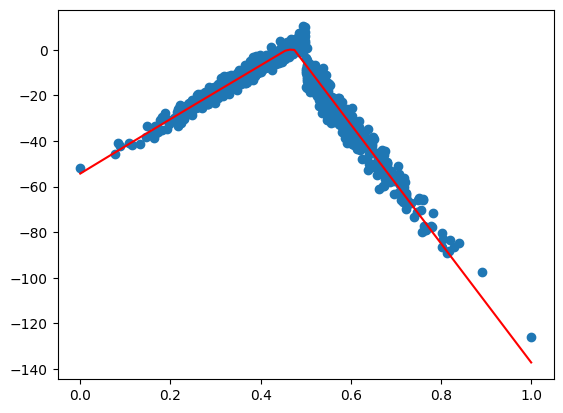

In [26]:
model_path = 'cifar_model.pt'
torch.save(dnn_3.state_dict(), model_path)

new_model = NeuralNetwork()
new_model.load_state_dict(torch.load(model_path))

plot_points(samples, y_new)
plot_module(dnn_3)